In [32]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *

from pyspark.sql.functions import col


init_engine()

In [36]:
learning_rate = 0.2
training_epochs = 15
batch_size = 16
display_step = 1

# Network Parameters
n_input = 4
n_classes = 3
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 10 # 2nd layer number of features

In [43]:
iris_training = spark.read.csv("../data/iris2/iris_training.csv", header=True, inferSchema="true", mode="DROPMALFORMED")
iris_test = spark.read.csv("../data/iris2/iris_test.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [44]:
iris_training = iris_training.select([col(c).cast("double") for c in iris_training.columns])
iris_test = iris_test.select([col(c).cast("double") for c in iris_test.columns])



In [45]:
iris_training.take(10)

[Row(feat1=6.4, feat2=2.8, feat3=5.6, feat4=2.2, label=3.0),
 Row(feat1=5.0, feat2=2.3, feat3=3.3, feat4=1.0, label=2.0),
 Row(feat1=4.9, feat2=2.5, feat3=4.5, feat4=1.7, label=3.0),
 Row(feat1=4.9, feat2=3.1, feat3=1.5, feat4=0.1, label=1.0),
 Row(feat1=5.7, feat2=3.8, feat3=1.7, feat4=0.3, label=1.0),
 Row(feat1=4.4, feat2=3.2, feat3=1.3, feat4=0.2, label=1.0),
 Row(feat1=5.4, feat2=3.4, feat3=1.5, feat4=0.4, label=1.0),
 Row(feat1=6.9, feat2=3.1, feat3=5.1, feat4=2.3, label=3.0),
 Row(feat1=6.7, feat2=3.1, feat3=4.4, feat4=1.4, label=2.0),
 Row(feat1=5.1, feat2=3.7, feat3=1.5, feat4=0.4, label=1.0)]

In [40]:
iris_test.filter('label == 0').show()

+-----+-----+-----+-----+-----+
|feat1|feat2|feat3|feat4|label|
+-----+-----+-----+-----+-----+
+-----+-----+-----+-----+-----+



In [46]:
iris_k_train = iris_training.rdd.map(list)
iris_k_test = iris_test.rdd.map(list)

In [25]:
iris_k_train.take(29)

[[6.4, 2.8, 5.6, 2.2, 3.0],
 [5.0, 2.3, 3.3, 1.0, 2.0],
 [4.9, 2.5, 4.5, 1.7, 3.0],
 [4.9, 3.1, 1.5, 0.1, 1.0],
 [5.7, 3.8, 1.7, 0.3, 1.0],
 [4.4, 3.2, 1.3, 0.2, 1.0],
 [5.4, 3.4, 1.5, 0.4, 1.0],
 [6.9, 3.1, 5.1, 2.3, 3.0],
 [6.7, 3.1, 4.4, 1.4, 2.0],
 [5.1, 3.7, 1.5, 0.4, 1.0],
 [5.2, 2.7, 3.9, 1.4, 2.0],
 [6.9, 3.1, 4.9, 1.5, 2.0],
 [5.8, 4.0, 1.2, 0.2, 1.0],
 [5.4, 3.9, 1.7, 0.4, 1.0],
 [7.7, 3.8, 6.7, 2.2, 3.0],
 [6.3, 3.3, 4.7, 1.6, 2.0],
 [6.8, 3.2, 5.9, 2.3, 3.0],
 [7.6, 3.0, 6.6, 2.1, 3.0],
 [6.4, 3.2, 5.3, 2.3, 3.0],
 [5.7, 4.4, 1.5, 0.4, 1.0],
 [6.7, 3.3, 5.7, 2.1, 3.0],
 [6.4, 2.8, 5.6, 2.1, 3.0],
 [5.4, 3.9, 1.3, 0.4, 1.0],
 [6.1, 2.6, 5.6, 1.4, 3.0],
 [7.2, 3.0, 5.8, 1.6, 3.0],
 [5.2, 3.5, 1.5, 0.2, 1.0],
 [5.8, 2.6, 4.0, 1.2, 2.0],
 [5.9, 3.0, 5.1, 1.8, 3.0],
 [5.4, 3.0, 4.5, 1.5, 2.0]]

In [47]:
#convert ndarray data into RDD[Sample]
def array2rdd(ds):
    #build Sample from ndarrays
    def build_sample(c0,c1,c2,c3,prediction):
        feature = np.array([c0,c1, c2, c3]).flatten()
        label = np.array(prediction)
        return Sample.from_ndarray(feature, label)
    rdd = ds.map(lambda (c0,c1,c2,c3,prediction): build_sample(c0,c1,c2,c3,prediction))
    return rdd

iris_rdd_train = array2rdd(iris_k_train)
iris_rdd_train.cache()
iris_rdd_train.count()

iris_rdd_test = array2rdd(iris_k_test)
iris_rdd_test.cache()
iris_rdd_test.count()

30

In [27]:
iris_rdd_test.f irst()

Sample: features: [JTensor: storage: [ 5.9000001   3.          4.19999981  1.5       ], shape: [4], float], label: JTensor: storage: [ 2.], shape: [1], float

In [28]:
# Create model

def multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    #model.add(Reshape([28*28]))
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_1, n_hidden_2).set_name('mlp_fc2'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_2, n_classes).set_name('mlp_fc3'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [48]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=iris_rdd_train,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=iris_rdd_test,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='multilayer_perceptron-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'multilayer_perceptron-20171110-174257')


In [49]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 8.58 s


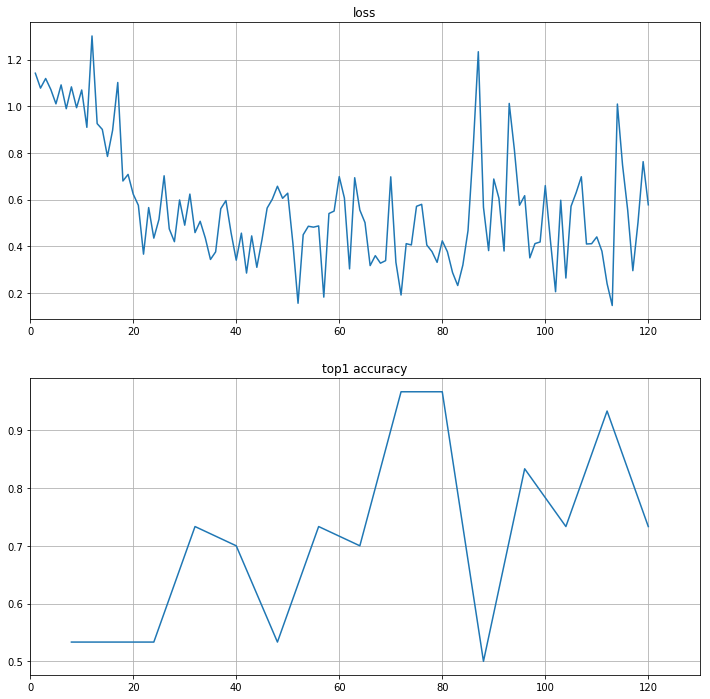

In [31]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)
